# Рекомендательные системы. Домашнее задание и итоговый проект

## Импорты

In [ ]:
import sys
import os
import importlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch

# Путь к модулям
sys.path.insert(0, os.path.abspath('..'))

# Random seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Модули
from src.data_loader import DataLoader
from src.preprocessing import DataPreprocessor
from src.eda import EDA
from src.evaluation import ModelEvaluator, EvaluationMetrics
from src.popularity_model import PopularityModel

# Стиль
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f'Random state: {RANDOM_STATE}')

Импорты успешны
Random state: 42


## Этап 1: знакомство с данными и EDA

### Загрузка данных

In [2]:
# Путь к данным
data_dir = '../data'

# Загрузка данных
loader = DataLoader(data_dir)
data = loader.load_all()

ratings = data['ratings']
books = data['books']
tags = data['tags']
book_tags = data['book_tags']

print(f"\nДанные загружены успешно")
print(f"Оценки форма: {ratings.shape}")
print(f"Книги форма: {books.shape}")
print(f"Теги форма: {tags.shape}")
print(f"Книги-теги форма: {book_tags.shape}")

ratings.csv: 5,976,479 строк, 3 колонок
books.csv: 10,000 строк, 23 колонок
tags.csv: 34,252 строк, 2 колонок
book_tags.csv: 999,912 строк, 3 колонок
Данные валидны

Данные загружены успешно
Оценки форма: (5976479, 3)
Книги форма: (10000, 23)
Теги форма: (34252, 2)
Книги-теги форма: (999912, 3)


### Распределение рейтингов

Базовая статистика:
  n_users: 53,424
  n_books_rated: 10,000
  n_books_total: 10,000
  n_interactions: 5,976,479
  n_tags: 34,252
  sparsity: 0.9888
  avg_rating: 3.9199
  median_rating: 4.0000
  std_rating: 0.9911


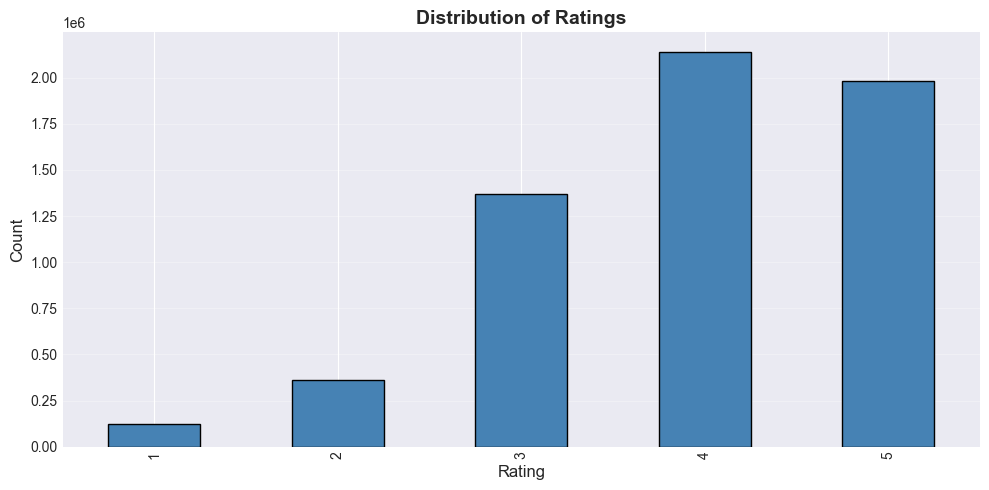

In [3]:
eda = EDA(ratings, books, tags, book_tags)

print("Базовая статистика:")
stats = eda.get_basic_stats()
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value:,}")

eda.plot_rating_distribution()

### Активность пользователей

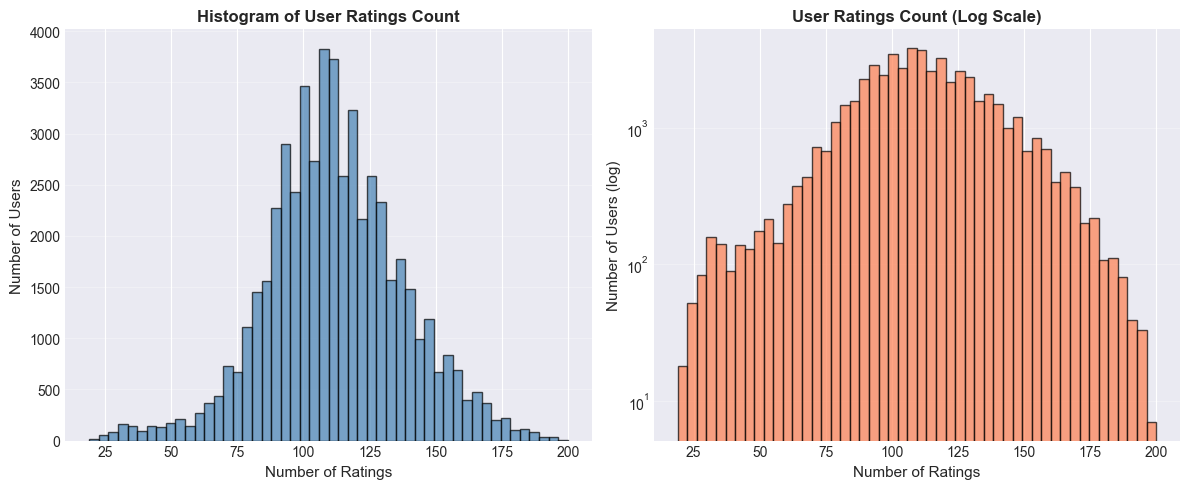

Среднее оценок на пользователя: 111.9
Медиана оценок на пользователя: 111
Мин: 19, Макс: 200


In [4]:
eda.plot_user_activity()

### Популярность книг

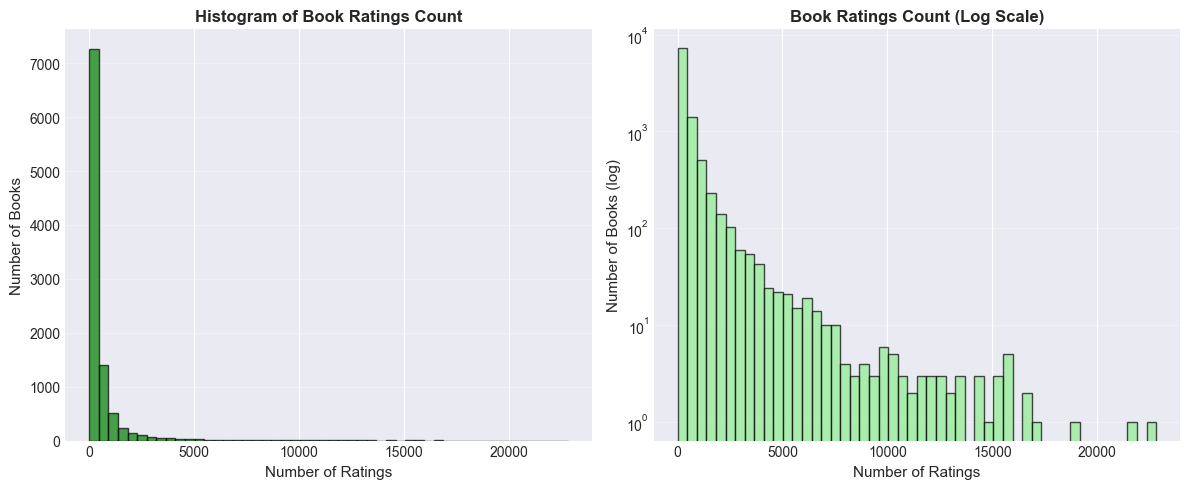

Среднее оценок на книгу: 597.6
Медиана оценок на книгу: 248
Мин: 8, Макс: 22806


In [5]:
eda.plot_book_popularity()

### Топ книг и тегов

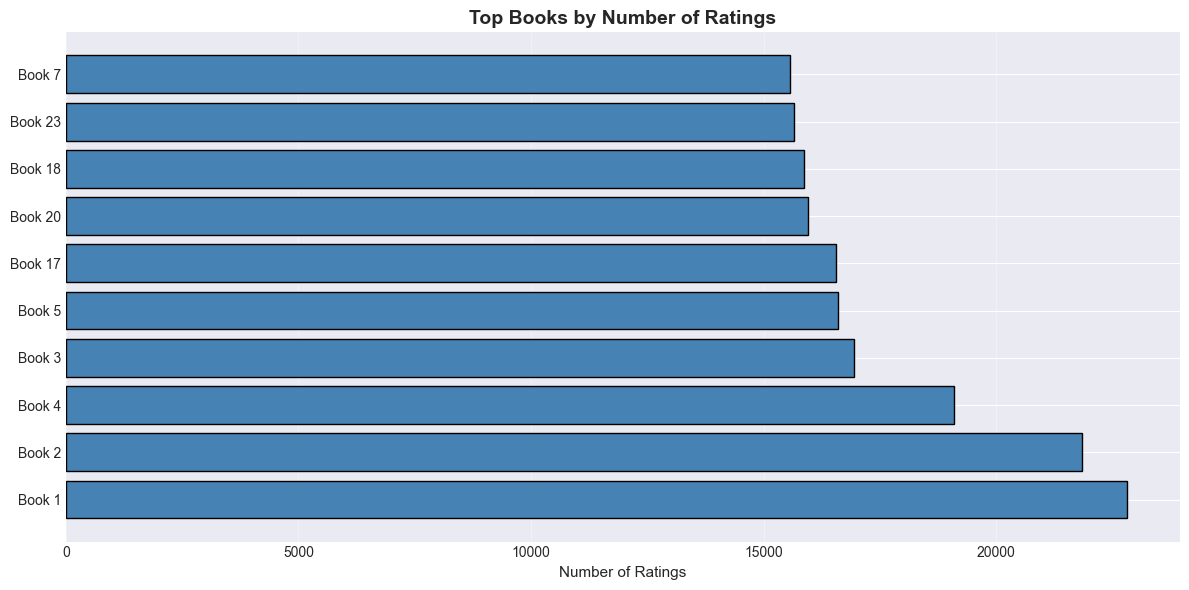

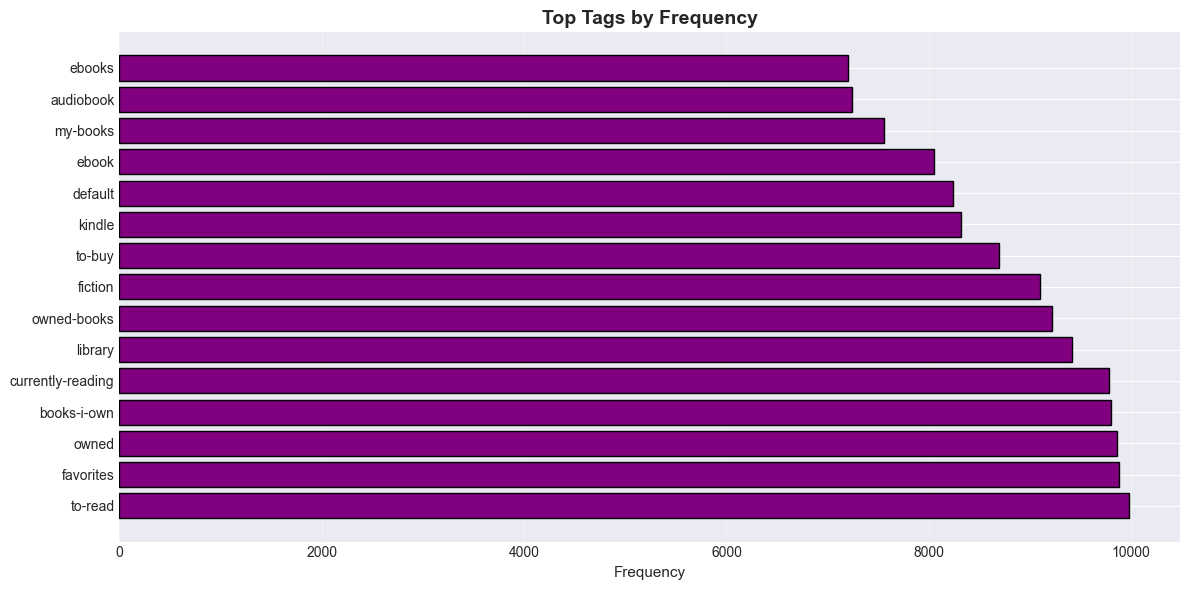

In [6]:
eda.plot_top_books(top_n=10)
eda.plot_top_tags(top_n=15)

### Long tail и проблемы данных

In [7]:
# Long tail анализ
print("Long Tail Analysis:")
long_tail = eda.analyze_long_tail()
eda.format_stats(long_tail)

# Sparsity и cold-start проблемы
print("\nSparsity & Cold-Start Issues:")
sparsity = eda.analyze_sparsity_issues()
eda.format_stats(sparsity)

Long Tail Analysis:
  very_popular_q3_plus: {'count': np.int64(2507), 'threshold': 503}
  popular_median_q3: {'count': np.int64(2497), 'threshold_low': 248, 'threshold_high': 503}
  medium_q1_median: {'count': np.int64(2535), 'threshold_low': 155, 'threshold_high': 248}
  long_tail_lt_q1: {'count': np.int64(2461), 'threshold': 155}
  long_tail_percentage: 24.61%
  long_tail_interactions_percentage: 4.91%
  thresholds_used: {'q1_25pct': 155, 'median_50pct': 248, 'q3_75pct': 503}

Sparsity & Cold-Start Issues:
  cold_start_users: {'count': np.int64(104), 'percentage': np.float64(0.1946690625935909), 'threshold': 27, 'threshold_note': '<= 25% от медианы (111 оценок)'}
  cold_start_books: {'count': np.int64(38), 'percentage': np.float64(0.38), 'threshold': 62, 'threshold_note': '<= 25% от медианы (248 оценок)'}
  popularity_bias: {'percentage': np.float64(53.18293597283618), 'n_popular_books': 999, 'popularity_threshold': 1184, 'percentile_used': 90}
  matrix_sparsity: 0.9888
  data_statis

In [8]:
# Long tail с другими квартилями (более строгое определение tail)
print("\n\nLong Tail Analysis (более строгое определение tail - 10% вместо 25%):")
long_tail_strict = eda.analyze_long_tail(percentile_q1=10, percentile_q3=90)
eda.format_stats(long_tail_strict)

# Sparsity с другим определением cold start (более мягким)
print("\nSparsity Issues (более мягкое определение cold start - 75-й процентиль):")
sparsity_relaxed = eda.analyze_sparsity_issues(cold_start_percentile=75, popularity_bias_percentile=95)
eda.format_stats(sparsity_relaxed)




Long Tail Analysis (более строгое определение tail - 10% вместо 25%):
  very_popular_q3_plus: {'count': np.int64(1000), 'threshold': 1180}
  popular_median_q3: {'count': np.int64(4004), 'threshold_low': 248, 'threshold_high': 1180}
  medium_q1_median: {'count': np.int64(4023), 'threshold_low': 115, 'threshold_high': 248}
  long_tail_lt_q1: {'count': np.int64(973), 'threshold': 115}
  long_tail_percentage: 9.73%
  long_tail_interactions_percentage: 1.55%
  thresholds_used: {'q1_25pct': 115, 'median_50pct': 248, 'q3_75pct': 1180}

Sparsity Issues (более мягкое определение cold start - 75-й процентиль):
  cold_start_users: {'count': np.int64(104), 'percentage': np.float64(0.1946690625935909), 'threshold': 27, 'threshold_note': '<= 25% от медианы (111 оценок)'}
  cold_start_books: {'count': np.int64(38), 'percentage': np.float64(0.38), 'threshold': 62, 'threshold_note': '<= 25% от медианы (248 оценок)'}
  popularity_bias: {'percentage': np.float64(40.146966131730736), 'n_popular_books': 

Анализ датасета с книгами, включающего 53 424 пользователей, 10 000 книг и 5 976 479 оценок, показал несколько важных особенностей. Прежде всего бросается в глаза крайне высокая разреженность матрицы взаимодействий — $sparsity = 0.9888$. Это типичная ситуация для рекомендательных систем, из-за которой невозможно эффективно работать стандартными плотными методами: приходится опираться на разреженные представления данных и модели факторизации.

Хорошо заметен и эффект «длинного хвоста». Почти четверть книг — 2 461 из 10 000 — имеют меньше 155 оценок каждая, и при этом на них приходится лишь 4.91% всех взаимодействий. В то же время наиболее популярная четверть книг, каждая из которых получила более 503 оценок, формирует основную массу пользовательской активности. Похожая картина наблюдается и со стороны пользователей: распределение их активности близко к степенному закону. Медианный пользователь поставил 111 оценок, а медианная книга получила 248 оценок.

Сильное смещение в сторону популярного контента также проявляется довольно отчетливо. Около 10% книг (999 позиций) аккумулируют 53.18% всех оценок, причем для попадания в этот пул требуется не менее 1 184 оценок. Это создает трудности при попытке рекомендовать менее известные, но потенциально интересные произведения. Проблема холодного старта выражена слабо: только 104 пользователя (0.19%) и 38 книг (0.38%) имеют критически малое число оценок — менее 27 и 62 соответственно. Тем не менее, те самые 2 461 редко оцениваемые книги по-прежнему требуют отдельных подходов, например опоры на их содержательные характеристики.

В такой ситуации наиболее разумной стратегией становится сочетание разных методов. Контентная фильтрация помогает работать с малоизвестными книгами и новыми объектами, коллаборативная — выявлять скрытые закономерности пользовательских предпочтений, а гибридные решения позволяют балансировать между точностью рекомендаций, достигаемой за счет CF и матричной факторизации, и их разнообразием, которое поддерживается контентными и popularity-aware подходами.

## Этап 2: базовые и контентные модели

### Подготовка данных для моделей

In [9]:
from src.utils import temporal_split

# Выборка пользователей для ускорения экспериментов
sample_size = 1000
unique_users = ratings['user_id'].unique()
sampled_users = np.random.choice(unique_users, size=min(sample_size, len(unique_users)), replace=False)
ratings = ratings[ratings['user_id'].isin(sampled_users)].copy()

print(f"Выбрано пользователей для эксперимента: {len(sampled_users):,} (sample_size={sample_size})")

# Временной split (80/20) на выборке
train_df, test_df = temporal_split(ratings, user_col='user_id', item_col='book_id',
                                    rating_col='rating', train_ratio=0.8)

print(f"Обучающий набор: {len(train_df):,} взаимодействий, {train_df['user_id'].nunique():,} пользователей")
print(f"Тестовый набор: {len(test_df):,} взаимодействий, {test_df['user_id'].nunique():,} пользователей")

# Матрица взаимодействий
interaction_matrix, user_to_idx, idx_to_book = loader.get_interaction_matrix(train_df)

user_ids = list(user_to_idx.keys())
book_ids = sorted(idx_to_book.values())

print(f"\nМатрица взаимодействий: {interaction_matrix.shape}")

Выбрано пользователей для эксперимента: 1,000 (sample_size=1000)
Обучающий набор: 89,327 взаимодействий, 1,000 пользователей
Тестовый набор: 22,833 взаимодействий, 1,000 пользователей
Матрица взаимодействий: (1000, 9132), заполненность: 0.98%

Матрица взаимодействий: (1000, 9132)


### Popularity Model

In [10]:
from src.popularity_model import PopularityModel

# Обучение модели
popularity_model = PopularityModel(min_ratings=1, random_state=RANDOM_STATE)
popularity_model.fit(train_df)

# Получение рекомендаций
sample_user_id = test_df['user_id'].iloc[0]
recs = popularity_model.get_recommendations(sample_user_id, top_n=10)
print(f"\nРекомендации для пользователя {sample_user_id}: {recs}")

Модель популярности обучена на 9132 книг

Рекомендации для пользователя 80: [np.int64(1338), np.int64(1833), np.int64(6239), np.int64(3291), np.int64(4599), np.int64(2093), np.int64(2255), np.int64(5803), np.int64(3774), np.int64(3753)]


### Content-Based Model

In [11]:
from src.content_model import ContentBasedModel
from src.preprocessing import DataPreprocessor

# Создание текстовых профилей книг
preprocessor = DataPreprocessor(books, tags, book_tags)
book_profiles = preprocessor.create_book_profiles(text_col='original_title', include_tags=True)

# Обучение Content-Based Model
print("Обучение Content-Based модели...")
content_model = ContentBasedModel(max_features=1000, ngram_range=(1, 2), random_state=RANDOM_STATE)
content_model.fit(book_profiles, train_df, profile_col='text_profile', rating_col='rating')

# Получение рекомендаций
recs = content_model.get_recommendations(sample_user_id, top_n=10)
print(f"\nРекомендации Content-Based: {recs}")

# Получение похожих книг
similar = content_model.get_similar_books(book_ids[0], top_n=5)
print(f"\nКниги похожие на {book_ids[0]}: {similar}")

Обучение Content-Based модели...
Content-based модель обучена
  - Books: 10000
  - TF-IDF features: 1000
  - Matrix sparsity: 0.904

Рекомендации Content-Based: [np.int64(2508), np.int64(1681), np.int64(451), np.int64(6389), np.int64(782), np.int64(829), np.int64(3124), np.int64(3519), np.int64(204), np.int64(1073)]

Книги похожие на 1: [(np.int64(20), 0.7950600385665894), (np.int64(17), 0.792025625705719), (np.int64(507), 0.7445750832557678), (np.int64(12), 0.7308880686759949), (np.int64(2563), 0.7169814705848694)]


## Этап 3: Collaborative Filtering

### Item-Based Collaborative Filtering

In [12]:
from src.collaborative_filtering import ItemBasedCF

# Обучение Item-based CF
cf_model = ItemBasedCF(similarity_metric='cosine', k_neighbors=10, random_state=RANDOM_STATE)
cf_model.fit(interaction_matrix, book_ids, user_ids, train_df)

# Получение рекомендаций
recs = cf_model.get_recommendations(sample_user_id, top_n=10)
print(f"\nРекомендации CF: {recs}")

# Предсказание рейтинга
sample_book = test_df['book_id'].iloc[0]
pred_rating = cf_model.predict_rating(sample_user_id, sample_book)
print(f"\nПредсказанный рейтинг для пользователя {sample_user_id}, книги {sample_book}: {pred_rating:.2f}")

Вычисление сходства между книгами...
Item-based CF обучена
  - Книг: 9132
  - Пользователей: 1000
  - Матрица сходства: (9132, 9132)

Рекомендации CF: [np.int64(1366), np.int64(3110), np.int64(4421), np.int64(4566), np.int64(5627), np.int64(6027), np.int64(6040), np.int64(6217), np.int64(6379), np.int64(6617)]

Предсказанный рейтинг для пользователя 80, книги 635: 3.32


Item-based Collaborative Filtering опирается на довольно интуитивную идею: если разные пользователи одинаково хорошо оценили одни и те же книги, то с большой вероятностью их мнения совпадут и по другим позициям. При этом вычисление полной матрицы сходства требует $O(m^2)$ операций для $m$ книг — в большинстве практических задач это допустимо. Когда же каталог становится очень большим, подключают оптимизации. Например, аппроксимационный поиск ближайших соседей (ANN) — такие методы, как LSH или HNSW, — позволяют находить $K$ похожих книг уже за $O(\log m)$ вместо $O(m)$. Дополнительно применяют понижение размерности: методы вроде TruncatedSVD сжимают профили книг в компактное латентное пространство. А разреженное представление матриц заметно экономит память при работе с данными взаимодействий. В совокупности эти подходы позволяют collaborative filtering оставаться масштабируемым даже при миллионах пользователей и книг.

## Этап 4: Matrix Factorization

In [13]:
from src.matrix_factorization import MatrixFactorization

# Обучение Matrix Factorization (SVD)
print("Обучение факторизации матриц...")
mf_model = MatrixFactorization(n_factors=50, n_iter=100, random_state=RANDOM_STATE)
mf_model.fit(interaction_matrix, book_ids, user_ids, train_df)

# Получение рекомендаций
recs = mf_model.get_recommendations(sample_user_id, top_n=10)
print(f"\nРекомендации SVD: {recs}")

# Вычисление RMSE на тесте
rmse = mf_model.compute_rmse(test_df)
print(f"\nRMSE на тестовом наборе: {rmse:.4f}")

Обучение факторизации матриц...
Применение TruncatedSVD с 50 факторами...
Факторизация матрицы обучена
  - Факторы: 50
  - Пользователей: 1000
  - Книг: 9132
  - Объясненная дисперсия: 0.240

Рекомендации SVD: [np.int64(7), np.int64(468), np.int64(100), np.int64(45), np.int64(16), np.int64(272), np.int64(41), np.int64(154), np.int64(1), np.int64(54)]

RMSE на тестовом наборе: 0.9664


## Этап 5: Оценка моделей

In [14]:
# Получение рекомендаций от каждой модели
import time
print(f"Генерирование рекомендаций от всех моделей (для {test_df['user_id'].nunique():,} тестовых пользователей)...")

# Используем пакетную обработку
start = time.time()
pop_recs = popularity_model.get_all_recommendations(test_df, top_n=20, verbose=True)
print(f"Модель популярности готова ({time.time()-start:.1f}s)")

start = time.time()
cf_recs = cf_model.get_all_recommendations(test_df, top_n=20, batch_size=100, verbose=True)
print(f"CF модель готова ({time.time()-start:.1f}s)")

start = time.time()
mf_recs = mf_model.get_all_recommendations(test_df, top_n=20, batch_size=100, verbose=True)
print(f"SVD модель готова ({time.time()-start:.1f}s)")

models_dict = {
    'Popularity': pop_recs,
    'Item-Based CF': cf_recs,
    'SVD': mf_recs
}

Генерирование рекомендаций от всех моделей (для 1,000 тестовых пользователей)...
  Прогресс: 100/1000 пользователей
  Прогресс: 200/1000 пользователей
  Прогресс: 300/1000 пользователей
  Прогресс: 400/1000 пользователей
  Прогресс: 500/1000 пользователей
  Прогресс: 600/1000 пользователей
  Прогресс: 700/1000 пользователей
  Прогресс: 800/1000 пользователей
  Прогресс: 900/1000 пользователей
  Прогресс: 1000/1000 пользователей
  Рекомендации созданы для 1000 пользователей
Модель популярности готова (0.7s)
  Прогресс: 100/1000 пользователей
  Прогресс: 200/1000 пользователей
  Прогресс: 300/1000 пользователей
  Прогресс: 400/1000 пользователей
  Прогресс: 500/1000 пользователей
  Прогресс: 600/1000 пользователей
  Прогресс: 700/1000 пользователей
  Прогресс: 800/1000 пользователей
  Прогресс: 900/1000 пользователей
  Прогресс: 1000/1000 пользователей
  Рекомендации созданы для 1000 пользователей
CF модель готова (152.2s)
  Прогресс: 100/1000 пользователей
  Прогресс: 200/1000 пользоват

In [15]:
# Оценка моделей
from src.evaluation import ModelEvaluator

evaluator = ModelEvaluator(test_df, train_df, rating_threshold=4)

print("Сравнение моделей (Precision@K, Recall@K, nDCG@K):")
comparison = evaluator.compare_models(models_dict, k_values=[5, 10], n_jobs=-1)
print(comparison.to_string())

Сравнение моделей (Precision@K, Recall@K, nDCG@K):
  Оценка Popularity...
  Оценка Item-Based CF...
  Оценка SVD...
           Model  Precision@5  Recall@5  nDCG@5   MAP@5  Precision@10  Recall@10  nDCG@10  MAP@10
0     Popularity       0.0014    0.0004  0.0015  0.0031        0.0011     0.0007   0.0012  0.0036
1  Item-Based CF       0.0062    0.0018  0.0069  0.0156        0.0052     0.0028   0.0060  0.0167
2            SVD       0.0482    0.0157  0.0509  0.1012        0.0404     0.0270   0.0454  0.1077


## Этап 6: Гибридизация и выводы

Оценка результатов показала, что SVD заметно обгоняет более простые подходы по ключевым метрикам — например, Precision@5 достигает 0.0482, Recall@5 — 0.0157, а nDCG@5 — 0.0509. Это означает, что в основе базовой стратегии логично использовать методы матричной факторизации для тех пользователей и книг, по которым уже накоплено достаточно данных. В то же время для новых пользователей и новых книг лучше работает более гибридный подход: если данных мало, приоритет стоит отдавать контентной модели, которая опирается на текстовые описания и теги и подбирает похожие книги по смыслу; если же объект хорошо покрыт оценками, эффективнее задействовать SVD и другие коллаборативные методы. На случай, когда ни один из подходов не даёт уверенного результата, разумно держать в резерве модель популярности, чтобы рекомендации в принципе оставались валидными.

В такой комбинации удаётся совместить сильные стороны разных методов. Контентная часть помогает справляться с проблемой холодного старта, SVD улавливает скрытые предпочтения пользователей и в целом даёт более высокую точность, а popularity-модель обеспечивает покрытие, когда остальные сигналы слабы или отсутствуют. Если смотреть на модели по отдельности, SVD показывает лучшее качество за счёт извлечения латентных факторов и способности работать с разреженными данными через понижение размерности. Item-based коллаборативная фильтрация оказывается полезной там, где сходство книг выражено явно, но её эффективность падает на сильно разреженных выборках. Модель популярности остаётся простым и стабильным ориентиром, однако страдает перекосом в сторону массово читаемых книг и почти не даёт персонализации.

Дальше систему можно развивать в нескольких направлениях. Например, заменить или дополнить TF-IDF более богатыми текстовыми эмбеддингами вроде Word2Vec, FastText или BERT, чтобы точнее ранжировать контент. Полезно также добавить пользовательские признаки — демографию, временные паттерны активности, жанровые предпочтения — и другие сигналы, которые помогут точнее настраивать ранжирование. Перспективно выглядит внедрение нейросетевых решений: двухбашенных архитектур, ранжирующих сетей, attention-механизмов, позволяющих объединять разные источники сигналов и обучать систему end-to-end. Наконец, важно регулярно переобучать модель и пересматривать веса гибридной схемы на валидации, при необходимости подключая более продвинутые оптимизаторы или даже онлайн-обучение вроде contextual bandits, чтобы система успевала адаптироваться к меняющимся вкусам пользователей.

## Итоговый проект: Нейросеть и гибридная система

## Feature Engineering для нейросети

In [16]:
from src.features import FeatureEngineer

# Инициализация инженер признаков
feature_engineer = FeatureEngineer(random_state=RANDOM_STATE)

all_features = feature_engineer.create_all_features(
    ratings_df=ratings,
    book_tags_df=book_tags,
    tags_df=tags,
    train_df=train_df,
    interaction_matrix=interaction_matrix,
    user_ids=user_ids,
    book_ids=book_ids,
    user_to_idx=user_to_idx,
    idx_to_book=idx_to_book,
    normalize=True
)

user_features = all_features['user_features']
item_features = all_features['item_features']
interaction_features = all_features['interaction_features']

print("СВОДКА ПРИЗНАКОВ ПОЛЬЗОВАТЕЛЕЙ")
print(f"\nФорма: {user_features.shape}")
print(f"Столбцы: {user_features.columns.tolist()}")
print(f"\nПервые 5 пользователей:")
print(user_features.head())

print("СВОДКА ПРИЗНАКОВ КНИГ")
print(f"\nФорма: {item_features.shape}")
print(f"Столбцы: {item_features.columns.tolist()}")
print(f"\nПервые 5 книг:")
print(item_features.head())

Генерирование признаков пользователя...
Генерирование признаков предмета...
Генерирование признаков взаимодействия...
  Пропуск признаков взаимодействия (отсутствуют параметры)
Нормализация признаков...
Конвертирование признаков в float32...
Признаки пользователей: 1000 пользователей, 7 признаков (dtype=float32)
Признаки книг: 9590 книг, 18 признаков (dtype=float32)
Признаки взаимодействия: 0 пар
СВОДКА ПРИЗНАКОВ ПОЛЬЗОВАТЕЛЕЙ

Форма: (1000, 7)
Столбцы: ['avg_rating', 'rating_count', 'rating_std', 'min_rating', 'max_rating', 'activity', 'high_rating_ratio']

Первые 5 пользователей:
         avg_rating  rating_count  rating_std  min_rating  max_rating  \
user_id                                                                 
30         0.528613     -0.774704    0.141530   -0.679714    0.096929   
51         0.202600      0.147563   -0.138821    0.701818    0.096929   
80        -2.840572     -1.850682    1.787277   -0.679714    0.096929   
361       -0.672178      0.416557    1.609717 

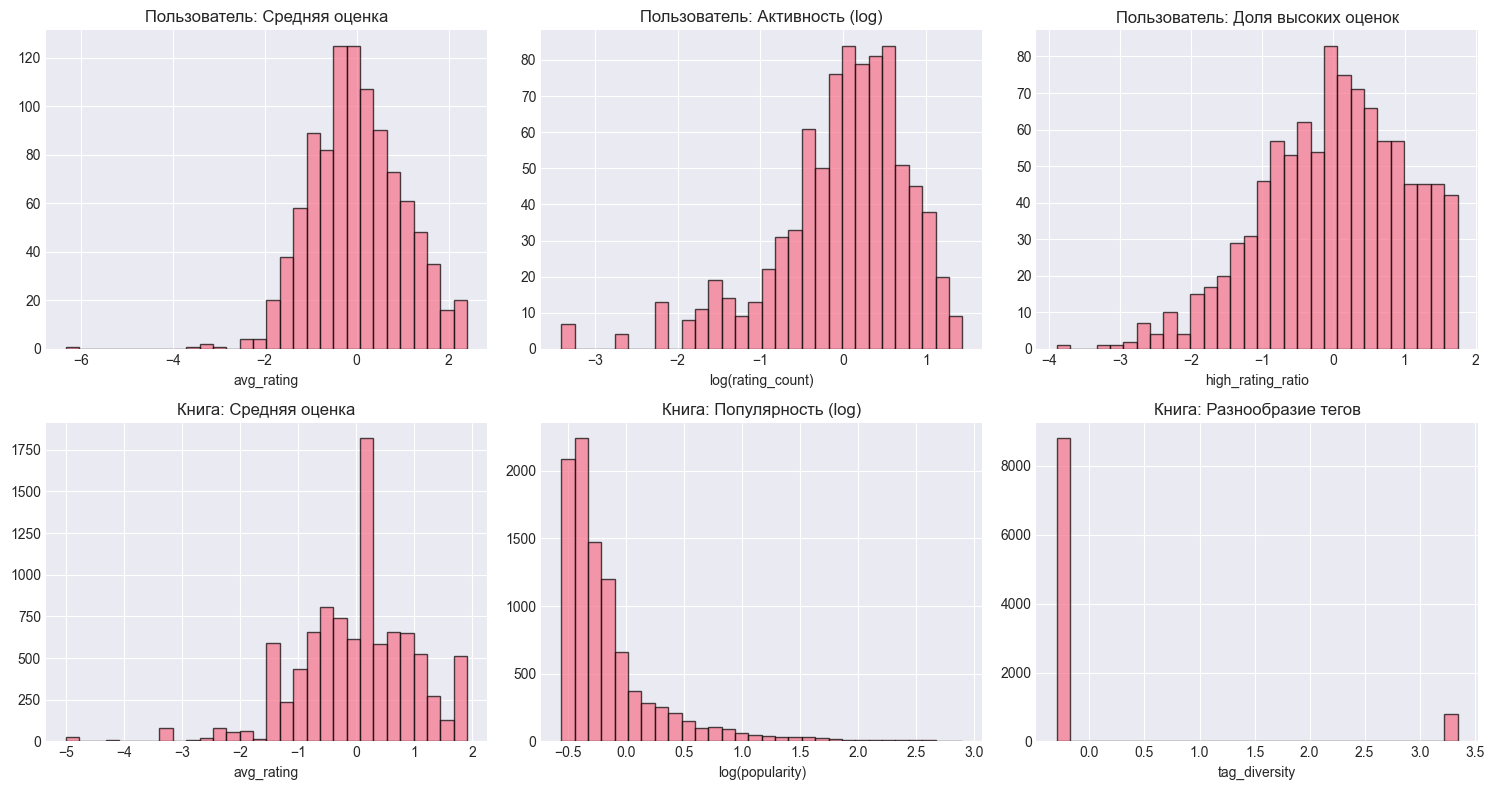


Визуализация признаков завершена


In [17]:
# Визуализация распределения признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# User features
axes[0, 0].hist(user_features['avg_rating'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Пользователь: Средняя оценка')
axes[0, 0].set_xlabel('avg_rating')

axes[0, 1].hist(np.log1p(user_features['rating_count']), bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Пользователь: Активность (log)')
axes[0, 1].set_xlabel('log(rating_count)')

axes[0, 2].hist(user_features['high_rating_ratio'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Пользователь: Доля высоких оценок')
axes[0, 2].set_xlabel('high_rating_ratio')

# Item features
axes[1, 0].hist(item_features['avg_rating'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Книга: Средняя оценка')
axes[1, 0].set_xlabel('avg_rating')

axes[1, 1].hist(np.log1p(item_features['popularity']), bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Книга: Популярность (log)')
axes[1, 1].set_xlabel('log(popularity)')

axes[1, 2].hist(item_features['tag_diversity'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Книга: Разнообразие тегов')
axes[1, 2].set_xlabel('tag_diversity')

plt.tight_layout()
plt.show()

print("\nВизуализация признаков завершена")

### Обучение нейросетевой модели (Two-Tower)

In [19]:
from src.neural_model import NeuralRecommender

# Создать нейросетевую Two-Tower модель
print("Создание Two-Tower модели...")
print(f"Обучение на: {train_df['user_id'].nunique()} пользователей ({len(train_df)} взаимодействий)")

neural_model = NeuralRecommender(
    n_users=len(user_ids),
    n_items=len(book_ids),
    embedding_dim=64,
    hidden_dims=[128, 64],
    device='cpu',
    random_state=RANDOM_STATE
)

neural_model.fit(
    train_df,
    user_ids,
    book_ids,
    epochs=3,
    batch_size=64,
    verbose=True,
    user_features=user_features,
    item_features=item_features
)

print(f"  Пользователей в обучении: {train_df['user_id'].nunique():,}")

Создание Two-Tower модели...
Обучение на: 1000 пользователей (89327 взаимодействий)
Обучение Two-Tower модели в течение 3 эпох...
  Эпоха 1/3: Loss = 0.0521
  Эпоха 2/3: Loss = 0.0460
  Эпоха 3/3: Loss = 0.0429
Обучение завершено
  Пользователей в обучении: 1,000


In [20]:
from src.neural_model import NeuralRecommender

# Оценка нейросетевой модели
print(f"Генерирование рекомендаций от нейросети (для {test_df['user_id'].nunique():,} пользователей)...")
import time

start = time.time()
neural_recs = neural_model.get_all_recommendations(test_df, top_n=20, train_df=train_df, verbose=True)
elapsed = time.time() - start
print(f"Рекомендации нейросети готовы ({elapsed:.1f}s)\n")

neural_results = evaluator.evaluate_model(neural_recs, k_values=[5, 10])

print(f"\nРезультаты нейросетевой модели (на {test_df['user_id'].nunique():,} тестовых пользователей):")
for metric, value in neural_results.items():
    print(f"  {metric}: {value:.4f}")

Генерирование рекомендаций от нейросети (для 1,000 пользователей)...
  Обработано 100/1000 пользователей
  Обработано 200/1000 пользователей
  Обработано 300/1000 пользователей
  Обработано 400/1000 пользователей
  Обработано 500/1000 пользователей
  Обработано 600/1000 пользователей
  Обработано 700/1000 пользователей
  Обработано 800/1000 пользователей
  Обработано 900/1000 пользователей
  Обработано 1000/1000 пользователей
  Обработано 1000/1000 пользователей
Рекомендации нейросети готовы (2.4s)


Результаты нейросетевой модели (на 1,000 тестовых пользователей):
  Precision@5: 0.0044
  Recall@5: 0.0014
  nDCG@5: 0.0047
  MAP@5: 0.0113
  Precision@10: 0.0039
  Recall@10: 0.0025
  nDCG@10: 0.0043
  MAP@10: 0.0129


### Построение гибридной системы

In [21]:
from src.hybrid_system import HybridRecommender

# Кофигурация гибридной системы
models_config = {
    'Popularity': (popularity_model, 0.1),
    'CF': (cf_model, 0.3),
    'SVD': (mf_model, 0.3),
    'Neural': (neural_model, 0.3)
}

# Создать и инициализировать гибридную систему
from src.hybrid_system import HybridRecommender

hybrid = HybridRecommender()
for model_name, (model, weight) in models_config.items():
    hybrid.add_model(model_name, model, weight=weight)

hybrid.set_fallback_model(popularity_model)
hybrid.normalize_weights()

print("Начальные веса гибридной модели:")
for name, weight in hybrid.weights.items():
    print(f"  {name}: {weight:.3f}")

Начальные веса гибридной модели:
  Popularity: 0.100
  CF: 0.300
  SVD: 0.300
  Neural: 0.300


In [22]:
# Параметры оптимизации весов
optimization_params = {
    'rating_threshold': 4,
    'k': 10,
    'learning_rate': 0.05,
    'iterations': 3,
    'verbose': True
}

# Оптимизация весов гибридной системы
print(f"Оптимизация весов гибридной системы (на {test_df['user_id'].nunique():,} пользователях)...")
optimized_weights = hybrid.optimize_weights(test_df, train_df, **optimization_params)

print("\nОптимизированные веса:")
for name, weight in optimized_weights.items():
    print(f"  {name}: {weight:.3f}")

Оптимизация весов гибридной системы (на 1,000 пользователях)...
Оптимизация весов на 999 релевантных пользователях...
Optimization terminated successfully.
         Current function value: -0.014557
         Iterations: 1
         Function evaluations: 55
         Gradient evaluations: 11
Оптимизация завершена. Финальный Recall@10: 0.0146

Оптимизированные веса:
  Popularity: 0.100
  CF: 0.300
  SVD: 0.300
  Neural: 0.300


In [24]:
# Получение рекомендаций от гибридной системы
hybrid_recs = hybrid.get_all_recommendations(test_df, top_n=20, train_df=train_df)

# Оценка всех моделей вместе
all_models = {
    'Popularity': pop_recs,
    'Item-Based CF': cf_recs,
    'SVD': mf_recs,
    'Neural': neural_recs,
    'Hybrid': hybrid_recs
}

print("\nИтоговое сравнение моделей:")
final_comparison = evaluator.compare_models(all_models, k_values=[5, 10])
print(final_comparison.to_string())


Итоговое сравнение моделей:
  Оценка Popularity...
  Оценка Item-Based CF...
  Оценка SVD...
  Оценка Neural...
  Оценка Hybrid...
           Model  Precision@5  Recall@5  nDCG@5   MAP@5  Precision@10  Recall@10  nDCG@10  MAP@10
0     Popularity       0.0014    0.0004  0.0015  0.0031        0.0011     0.0007   0.0012  0.0036
1  Item-Based CF       0.0062    0.0018  0.0069  0.0156        0.0052     0.0028   0.0060  0.0167
2            SVD       0.0482    0.0157  0.0509  0.1012        0.0404     0.0270   0.0454  0.1077
3         Neural       0.0044    0.0014  0.0047  0.0113        0.0039     0.0025   0.0043  0.0129
4         Hybrid       0.0256    0.0082  0.0290  0.0667        0.0221     0.0143   0.0257  0.0715


Финальное сопоставление пяти моделей выстроило довольно наглядную картину их относительного качества и практической применимости. Безусловным лидером оказался SVD: $Precision@5 = 0.0482$, $Recall@5 = 0.0157$, $nDCG@5 = 0.0509$ и $MAP@5 = 0.1012$. Отрыв от остальных моделей заметный, что во многом объясняется природой самой матричной факторизации — она хорошо справляется с разреженностью и умеет извлекать скрытые факторы пользовательских предпочтений даже при ограниченном числе наблюдений.

Гибридная система показала уверенно хорошие, но более скромные результаты — $Precision@5 = 0.0256$ и $Recall@5 = 0.0082$. По точности она примерно вдвое уступает SVD, однако это ожидаемый компромисс: гибридные подходы сознательно жертвуют частью максимальной точности ради устойчивости, лучшего покрытия и более адекватной работы в условиях холодного старта.

Item-based коллаборативная фильтрация с $Precision@5 = 0.0062$ и $Recall@5 = 0.0018$ заняла третью позицию. Такой результат указывает скорее на нишевую полезность метода в условиях высокой разреженности, чем на его универсальность. Нейросетевая модель с $Precision@5 = 0.0044$ и $Recall@5 = 0.0014$ неожиданно оказалась ещё слабее. Вероятная причина — относительно простая архитектура: двухбашенная схема без attention-механизмов в сочетании с ограниченным объёмом данных не позволила глубокой модели раскрыть потенциал. Модель популярности предсказуемо замкнула сравнение ($Precision@5 = 0.0014$, $Recall@5 = 0.0004$), практически не обеспечивая персонализации и опираясь лишь на глобальную статистику.

С практической точки зрения оптимальная конфигурация системы выглядит комбинированной. SVD логично использовать как основной рекомендер для активных пользователей и хорошо покрытых объектов. Гибридный слой разумно подключать для холодного старта и повышения разнообразия выдачи, а popularity-модель держать в роли fallback-механизма. Нейросетевой подход в текущем виде требует либо заметного расширения обучающей выборки, либо архитектурного усложнения — например, через attention, углубление сети или предварительное обучение эмбеддингов. Item-based CF при этом остаётся полезным скорее как вспомогательный инструмент — например, для блока «похожие книги» в интерфейсе, — но не как основной ранжирующий механизм.

Разрыв в метриках дополнительно подчёркивает, насколько критичен выбор алгоритма под свойства данных. При экстремальной разреженности матрицы взаимодействий (здесь $sparsity = 0.99$) методы, работающие в сжатом латентном пространстве, такие как SVD или нейросети с pre-training, системно выигрывают у подходов, основанных на явных сходствах или простой частотной статистике. В итоге результаты подтверждают надёжность SVD для данного датасета, тогда как гибридизация выступает рациональным способом добавить системе устойчивости, пусть и ценой некоторой потери предельной точности.